In [1]:
from utils import *
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import time

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['negative', 'positive']
10662
10662


In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(trainset.data, trainset.target, test_size = 0.2)

In [4]:
concat = ' '.join(trainset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 20332
Most common words [('film', 1453), ('movie', 1270), ('one', 727), ('like', 721), ('story', 477), ('much', 386)]
Sample data [562, 2576, 3242, 16592, 36, 8849, 218, 150, 19, 4349] ['rock', 'destined', '21st', 'centurys', 'new', 'conan', 'hes', 'going', 'make', 'splash']


In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = len(trainset.target_names)
learning_rate = 1e-3
maxlen = 50
batch_size = 128

In [7]:
class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output, learning_rate):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.LSTMCell(size_layer,initializer=tf.orthogonal_initializer(),reuse=reuse)
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        batch_size = tf.shape(self.X)[0]
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        outputs, last_state = tf.nn.dynamic_rnn(tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)]), 
                                                encoder_embedded, dtype = tf.float32)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(num_units = size_layer, 
                                                                    memory = outputs)
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(cell = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)]), 
                                                        attention_mechanism = attention_mechanism,
                                                        attention_layer_size = size_layer,
                                                       alignment_history=True)
        decoder_outputs, decoder_last_state = tf.nn.dynamic_rnn(rnn_cells, encoder_embedded, 
                                                                initial_state = rnn_cells.zero_state(batch_size, tf.float32).clone(cell_state=last_state),
                                                                dtype = tf.float32)
        self.alignments = tf.transpose(decoder_last_state.alignment_history.stack(),[1,2,0])
        W = tf.get_variable('w',shape=(size_layer, dimension_output),initializer=tf.orthogonal_initializer())
        b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
        self.logits = tf.matmul(outputs[:, -1], W) + b
        self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        correct_pred = tf.equal(tf.argmax(self.logits, 1,output_type=tf.int32), self.Y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,len(dictionary),dimension_output,learning_rate)
sess.run(tf.global_variables_initializer())

In [9]:
EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 5, 0, 0, 0
while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n'%(EPOCH))
        break
        
    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    for i in range(0, (len(train_X) // batch_size) * batch_size, batch_size):
        batch_x = str_idx(train_X[i:i+batch_size],dictionary,maxlen)
        acc, loss, _ = sess.run([model.accuracy, model.cost, model.optimizer], 
                           feed_dict = {model.X : batch_x, model.Y : train_Y[i:i+batch_size]})
        train_loss += loss
        train_acc += acc
    
    for i in range(0, (len(test_X) // batch_size) * batch_size, batch_size):
        batch_x = str_idx(test_X[i:i+batch_size],dictionary,maxlen)
        acc, loss = sess.run([model.accuracy, model.cost], 
                           feed_dict = {model.X : batch_x, model.Y : test_Y[i:i+batch_size]})
        test_loss += loss
        test_acc += acc
    
    train_loss /= (len(train_X) // batch_size)
    train_acc /= (len(train_X) // batch_size)
    test_loss /= (len(test_X) // batch_size)
    test_acc /= (len(test_X) // batch_size)
    
    if test_acc > CURRENT_ACC:
        print('epoch: %d, pass acc: %f, current acc: %f'%(EPOCH,CURRENT_ACC, test_acc))
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time()-lasttime)
    print('epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'%(EPOCH,train_loss,
                                                                                          train_acc,test_loss,
                                                                                          test_acc))
    EPOCH += 1

epoch: 0, pass acc: 0.000000, current acc: 0.621582
time taken: 2.827195882797241
epoch: 0, training loss: 0.677005, training acc: 0.564157, valid loss: 0.647610, valid acc: 0.621582

epoch: 1, pass acc: 0.621582, current acc: 0.677246
time taken: 2.7505533695220947
epoch: 1, training loss: 0.562928, training acc: 0.711529, valid loss: 0.616340, valid acc: 0.677246

epoch: 2, pass acc: 0.677246, current acc: 0.702637
time taken: 2.758648633956909
epoch: 2, training loss: 0.416040, training acc: 0.807292, valid loss: 0.648595, valid acc: 0.702637

epoch: 3, pass acc: 0.702637, current acc: 0.709961
time taken: 2.7736120223999023
epoch: 3, training loss: 0.282594, training acc: 0.877131, valid loss: 0.739679, valid acc: 0.709961

epoch: 4, pass acc: 0.709961, current acc: 0.723633
time taken: 2.758371114730835
epoch: 4, training loss: 0.173980, training acc: 0.930043, valid loss: 1.054135, valid acc: 0.723633

time taken: 2.789628267288208
epoch: 5, training loss: 0.103915, training acc:

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
heatmap=sess.run(model.alignments,feed_dict={model.X:str_idx(test_X[1:2],dictionary,len(test_X[1].split()))})

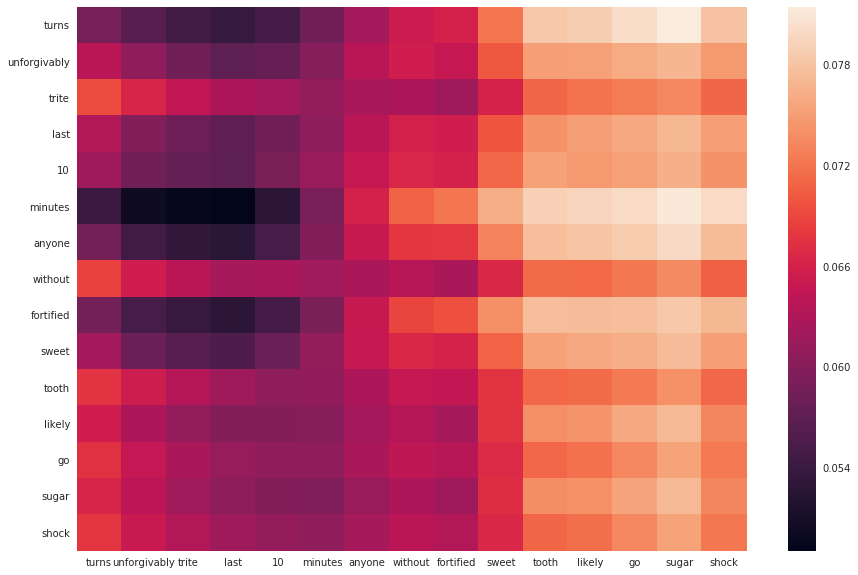

In [30]:
plt.figure(figsize=(15,10))
sns.heatmap(heatmap[:,0,:],
           xticklabels=test_X[1].split(),yticklabels=test_X[1].split())
plt.show()